In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format


import warnings
warnings.filterwarnings('ignore')

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices_df = pd.read_sql_query('select * from houseprices', con=engine)

engine.dispose()

In [5]:
#Quick check on the number of rows and the columns in the dataframe
print(len(house_prices_df))
house_prices_df.iloc[:,:81].head(5)

1460


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


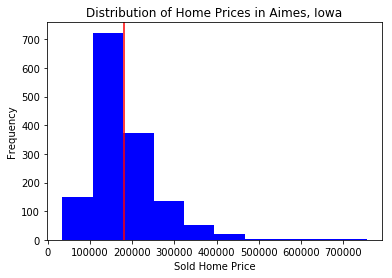

Mean house price in Aimes:  180921.19589041095


In [6]:
#Since we are estimating the saleprice I want to check the distribution
plt.hist(house_prices_df['saleprice'], color ='b')
plt.xlabel('Sold Home Price')
plt.ylabel('Frequency')
plt.axvline(house_prices_df['saleprice'].mean(), color='r', alpha=1.0)
plt.title('Distribution of Home Prices in Aimes, Iowa')
plt.show()
print('Mean house price in Aimes: ', house_prices_df['saleprice'].mean())

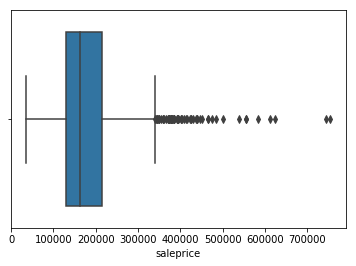

In [7]:
sns.boxplot(house_prices_df['saleprice'])
plt.show()

### Feature Engineering

In [8]:
house_prices_df['total_sf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

In [9]:
num_car_garage = pd.get_dummies(house_prices_df['garagecars'], prefix='car_garage')
house_prices_df = pd.concat([house_prices_df, num_car_garage], axis=1)


In [10]:
garage_type = pd.get_dummies(house_prices_df['garagetype'], prefix='garagetype')
house_prices_df = pd.concat([house_prices_df, garage_type], axis=1)


In [11]:
paved = pd.get_dummies(house_prices_df['paveddrive'], prefix='paved_driveway')
house_prices_df = pd.concat([house_prices_df, paved], axis=1)

In [12]:
garage_finish = pd.get_dummies(house_prices_df['garagefinish'], prefix='garagefinish')
house_prices_df = pd.concat([house_prices_df, garage_finish], axis=1)

In [13]:
#Does the house have an above average kitchen feature
house_prices_df['awesome_kitchen'] = 9999

In [14]:
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Ex') | (house_prices_df['kitchenqual'] == 'Gd'), 
                    ['awesome_kitchen']] = 1
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Fa') | (house_prices_df['kitchenqual'] == 'TA'), 
                    ['awesome_kitchen']] = 0
house_prices_df.awesome_kitchen.value_counts()

0    774
1    686
Name: awesome_kitchen, dtype: int64

In [15]:
#Is the garage attached to the house feature
house_prices_df['attached_garage'] = 9999
house_prices_df.loc[(house_prices_df['garagetype'] == 'Attchd') | (house_prices_df['garagetype'] == 'BuiltIn'), 
                    ['attached_garage']] = 1
house_prices_df.loc[(house_prices_df['garagetype'] != 'Attchd') & (house_prices_df['garagetype'] != 'BuiltIn'), 
                    ['attached_garage']] = 0
house_prices_df.attached_garage.value_counts()

1    958
0    502
Name: attached_garage, dtype: int64

In [16]:
house_prices_df['yard_sf'] = house_prices_df['lotarea'] - house_prices_df['firstflrsf']

In [17]:
hillside = pd.get_dummies(house_prices_df['landcontour'], prefix='landcontour')
house_prices_df = pd.concat([house_prices_df, hillside], axis=1)

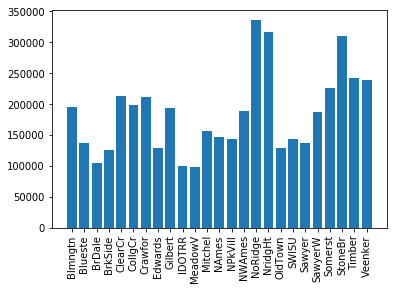

0    1317
1     143
Name: pricey_neighborhoods, dtype: int64
pricey_neighborhoods
0   165742.236
1   320716.231
Name: saleprice, dtype: float64
pricey_neighborhoods
0   0.414
1   0.986
Name: awesome_kitchen, dtype: float64


In [18]:
plt.bar(house_prices_df.groupby('neighborhood')['saleprice'].mean().index, 
        house_prices_df.groupby('neighborhood')['saleprice'].mean())
plt.xticks(rotation=90)
plt.show()

house_prices_df['pricey_neighborhoods'] = 9999
house_prices_df.loc[(house_prices_df.neighborhood == 'NoRidge') | 
                    (house_prices_df.neighborhood == 'NridgHt') | 
                    (house_prices_df.neighborhood == 'StoneBr'), 
                    ['pricey_neighborhoods']] = 1
house_prices_df.loc[(house_prices_df.neighborhood != 'NoRidge') & 
                    (house_prices_df.neighborhood != 'NridgHt') & 
                    (house_prices_df.neighborhood != 'StoneBr'), 
                    ['pricey_neighborhoods']] = 0   

print(house_prices_df.pricey_neighborhoods.value_counts())
print(house_prices_df.groupby('pricey_neighborhoods')['saleprice'].mean())
print(house_prices_df.groupby('pricey_neighborhoods')['awesome_kitchen'].mean())

In [19]:
house_prices_df.groupby('pricey_neighborhoods').total_sf.describe()

house_prices_df['pricey_hood_grt4000'] = 9999
house_prices_df.loc[(house_prices_df.pricey_neighborhoods == 1) & 
       (house_prices_df.total_sf > 4000), 
       ['pricey_hood_grt4000']] = 1
house_prices_df.loc[(house_prices_df.pricey_neighborhoods == 1) & 
       (house_prices_df.total_sf < 4000), 
       ['pricey_hood_grt4000']] = 0
house_prices_df.loc[house_prices_df.pricey_neighborhoods == 0, 
       ['pricey_hood_grt4000']] = 0
house_prices_df.pricey_hood_grt4000.value_counts()

0    1425
1      35
Name: pricey_hood_grt4000, dtype: int64

### OLS iteration

In [104]:
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'garagetype_2Types', 
                    'car_garage_3', 
                    'garagefinish_Fin', 
                    'yard_sf', 
                    'landcontour_HLS', 
                    'pricey_neighborhoods', 
                    'pricey_hood_grt4000'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 465)

print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in validation: {}'.format(len(X_val)))
print('The number of observations in test: {}'.format(len(X_test)))

s = StandardScaler()
X_train = s.fit_transform(X_train)
X_val = s.transform(X_val)
X_test = s.transform(X_test)

lrm = LinearRegression()
lrm.fit(X_train, Y_train)

Y_train_pred = lrm.predict(X_train)
Y_val_pred = lrm.predict(X_val)

mae = mean_absolute_error(Y_val, Y_val_pred)
mean_sq_err = mse(Y_val, Y_val_pred)
root_mse = rmse(Y_val, Y_val_pred)
ma_perc_err = np.mean(np.abs((Y_val - Y_val_pred) / Y_val)) *100
print('\n***** Training Set Statistics *****')
print('\nR-squared of the training set is: {}'.format(lrm.score(X_train, Y_train)))
print('Root mean squared error of the training set is: ', rmse(Y_train, Y_train_pred))
print('\n***** Validation Set Statistics *****')
print('\nR-squared of the validation set is: {}'.format(lrm.score(X_val, Y_val)))
print('Mean absolute error of the prediction is: ', mae)
print('Mean squared error of the prediction is: ', mean_sq_err)
print('Root mean squared error of the prediction is: ', root_mse)
print('Mean absolute percentage error of the prediction is: ', ma_perc_err)

The number of observations in training: 934
The number of observations in validation: 234
The number of observations in test: 292

***** Training Set Statistics *****

R-squared of the training set is: 0.7896793115475562
Root mean squared error of the training set is:  34806.42308457221

***** Validation Set Statistics *****

R-squared of the validation set is: 0.8208859410725159
Mean absolute error of the prediction is:  24729.581580782382
Mean squared error of the prediction is:  1427482888.9510393
Root mean squared error of the prediction is:  37782.044531113446
Mean absolute percentage error of the prediction is:  14.872179914205466


### Ridge Iteration

In [105]:
#First need to determine the optimal alpha parameter
alpha = [.001, .01, .1, 1, 10, 1e3, 1e6, 1e9, 1e12, 1e24]

for i in alpha:
    rr = Ridge(alpha=i)
    rrcv = cross_val_score(rr, X_train, Y_train, cv=10).reshape(2,5)
    print('Cross validation of training set when alpha = {:0.1e}:\n{}\n'.format(int(i), rrcv))
    print('Mean of Cross Validation scores: {:0.3}\n'.format(rrcv.mean()))
    
for i in alpha:
    rr = Ridge(alpha=i)
    rrcv = cross_val_score(rr, X_val, Y_val, cv=10).reshape(2,5)
    print('Cross validation of validation set when alpha = {:0.1e}:\n{}\n'.format(int(i), rrcv))
    print('Mean of Cross Validation scores: {:0.3}\n'.format(rrcv.mean()))


Cross validation of training set when alpha = 0.0e+00:
[[0.82569968 0.54467423 0.85051734 0.79056968 0.21740609]
 [0.80966324 0.78987695 0.82536142 0.7882053  0.88302392]]

Mean of Cross Validation scores: 0.732

Cross validation of training set when alpha = 0.0e+00:
[[0.82569877 0.54467804 0.850517   0.79056884 0.21741975]
 [0.80966274 0.78987666 0.82536063 0.78820444 0.88302433]]

Mean of Cross Validation scores: 0.733

Cross validation of training set when alpha = 0.0e+00:
[[0.8256897  0.54471621 0.85051352 0.79056038 0.21755627]
 [0.80965768 0.78987367 0.82535274 0.78819586 0.88302842]]

Mean of Cross Validation scores: 0.733

Cross validation of training set when alpha = 1.0e+00:
[[0.82559894 0.54509679 0.85047864 0.79047585 0.21891698]
 [0.80960699 0.78984375 0.82527382 0.78811006 0.8830692 ]]

Mean of Cross Validation scores: 0.733

Cross validation of training set when alpha = 1.0e+01:
[[0.82468615 0.54880267 0.85011958 0.78963383 0.23208967]
 [0.80908787 0.78953495 0.82447842 

Based on the statistics above, it looks like alpha = 1 yields the most consistent cross validation scores without diminishing returns in both the test and validation sets for Ridge Regression. I will use alpha = 1 for the Ridge model going forward.

In [106]:
rr = Ridge(alpha=1)
rr.fit(X_train, Y_train)

Y_train_pred = rr.predict(X_train)
Y_val_pred = rr.predict(X_val)

mae = mean_absolute_error(Y_val, Y_val_pred)
mean_sq_err = mse(Y_val, Y_val_pred)
root_mse = rmse(Y_val, Y_val_pred)
ma_perc_err = np.mean(np.abs((Y_val - Y_val_pred) / Y_val)) *100

print('\n***** Training Set Statistics *****')
print('\nR-squared of the training set is: {}'.format(rr.score(X_train, Y_train)))
print('Root mean squared error of the training set is: ', rmse(Y_train, Y_train_pred))
print('\n***** Validation Set Statistics *****')
print('\nR-squared of the validation set is: {}'.format(rr.score(X_val, Y_val)))
print('Mean absolute error of the prediction is: ', mae)
print('Mean squared error of the prediction is: ', mean_sq_err)
print('Root mean squared error of the prediction is: ', root_mse)
print('Mean absolute percentage error of the prediction is: ', ma_perc_err)


***** Training Set Statistics *****

R-squared of the training set is: 0.7896791521436417
Root mean squared error of the training set is:  34806.43627461805

***** Validation Set Statistics *****

R-squared of the validation set is: 0.8207732087027385
Mean absolute error of the prediction is:  24733.499934615356
Mean squared error of the prediction is:  1428381330.591253
Root mean squared error of the prediction is:  37793.93245735687
Mean absolute percentage error of the prediction is:  14.874908168531306


The ridge regression model using alpha=1 performs basically the same as the linear regression model. Both the training and validation R-squareds have decreased and all other predictive validation statistics have increased. The difference in the training and validation R-squareds is larger than that of the linear regression model (0.003 vs. -.04).

### Lasso Iteration

In [107]:
#first we need to determine the alpha parameter
alpha = [.01, .1, 1, 10, 1e3, 1e6, 1e9, 1e12, 1e24]

for i in alpha:
    lasso_regr = Lasso(alpha=i)
    lasso_cv = cross_val_score(lasso_regr, X_train, Y_train, cv=10).reshape(2,5)
    print('Cross validation of training set when alpha = {:0.1e}:\n{}\n'.format(int(i), lasso_cv))
    print('Standard deviation of Cross Validation scores: {:0.3}'.format(lasso_cv.std()))
    print('Mean of Cross Validation scores: {:0.3}\n'.format(lasso_cv.mean()))
    
for i in alpha:
    lasso_regr = Lasso(alpha=i)
    lasso_cv = cross_val_score(lasso_regr, X_val, Y_val, cv=10).reshape(2,5)
    print('Cross validation of validation set when alpha = {:0.1e}:\n{}\n'.format(int(i), lasso_cv))
    print('Standard deviation of Cross Validation scores: {:0.3}'.format(lasso_cv.std()))
    print('Mean of Cross Validation scores: {:0.3}\n'.format(lasso_cv.mean()))

Cross validation of training set when alpha = 0.0e+00:
[[0.8256997  0.54467389 0.85051741 0.79056979 0.21740456]
 [0.80966328 0.78987701 0.82536142 0.78820534 0.88302396]]

Standard deviation of Cross Validation scores: 0.192
Mean of Cross Validation scores: 0.732

Cross validation of training set when alpha = 0.0e+00:
[[0.82569898 0.54467456 0.85051773 0.79056982 0.21740495]
 [0.80966318 0.78987723 0.82536075 0.78820493 0.88302476]]

Standard deviation of Cross Validation scores: 0.192
Mean of Cross Validation scores: 0.732

Cross validation of training set when alpha = 1.0e+00:
[[0.82569166 0.5446828  0.85052053 0.79057005 0.21741246]
 [0.80966185 0.78987917 0.82535362 0.7882004  0.88303249]]

Standard deviation of Cross Validation scores: 0.192
Mean of Cross Validation scores: 0.733

Cross validation of training set when alpha = 1.0e+01:
[[0.82561722 0.54476358 0.85054734 0.79057215 0.21749522]
 [0.80964869 0.78989711 0.82528165 0.7881542  0.88310876]]

Standard deviation of Cross V

Based on the standard deviations of the cross validation sets, alpha=1e9 performs the best without diminishing returns. The 1e12 and 1e24 sets showed the same performace as the 1e9.

In [108]:
lasso_regr = Lasso(alpha=10)
lasso_regr.fit(X_train, Y_train)

Y_train_pred = lasso_regr.predict(X_train)
Y_val_pred = lasso_regr.predict(X_val)

mae = mean_absolute_error(Y_val, Y_val_pred)
mean_sq_err = mse(Y_val, Y_val_pred)
root_mse = rmse(Y_val, Y_val_pred)
ma_perc_err = np.mean(np.abs((Y_val - Y_val_pred) / Y_val)) *100

print('\n***** Training Set Statistics *****')
print('\nR-squared of the training set is: {}'.format(lasso_regr.score(X_train, Y_train)))
print('Root mean squared error of the training set is: ', rmse(Y_train, Y_train_pred))
print('\n***** Validation Set Statistics *****')
print('\nR-squared of the validation set is: {}'.format(lasso_regr.score(X_val, Y_val)))
print('Mean absolute error of the prediction is: ', mae)
print('Mean squared error of the prediction is: ', mean_sq_err)
print('Root mean squared error of the prediction is: ', root_mse)
print('Mean absolute percentage error of the prediction is: ', ma_perc_err)

print(lasso_regr.fit(X_train, Y_train).coef_)


***** Training Set Statistics *****

R-squared of the training set is: 0.7896792166318454
Root mean squared error of the training set is:  34806.43093847389

***** Validation Set Statistics *****

R-squared of the validation set is: 0.820841566298351
Mean absolute error of the prediction is:  24730.804623933156
Mean squared error of the prediction is:  1427836541.9875498
Root mean squared error of the prediction is:  37786.72441463469
Mean absolute percentage error of the prediction is:  14.872834944826948
[13991.80645494 26936.14969315  3569.83799081  7752.95791379
 -3805.59579386 14173.42610189  7082.9507818   6509.63839557
  5404.0109727  14217.47564372  9901.04723274]


For the test set and the validation set, the Lasso model performs very poorly. The R-squared for both models is zero and below. All of the error statistics for the prediction have increased from the OLS model, which highlights the poor performance. This model has actually performed worse than the Ridge model that was done above.

### ElasticNet Iteration

In [134]:
alpha = [.01, .1, 1, 10, 1e3, 1e6, 1e9, 1e12, 1e24]
l1_ratio = [.01, .1, 1, 10, 1e3, 1e6, 1e9, 1e12, 1e24]
opt = BayesSearchCV(ElasticNet(), {'alpha':Real(.001,1e24, prior='normal'), 'l1_ratio':Real(.001,1e24, prior='normal')}, cv=10, random_state=15)
opt.fit(X_train, Y_train)

BayesSearchCV(cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_iter=50, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=15,
       refit=True, return_train_score=False, scoring=None,
       search_spaces={'alpha': Real(low=0.001, high=1e+24, prior='normal', transform='identity'), 'l1_ratio': Real(low=0.001, high=1e+24, prior='normal', transform='identity')},
       verbose=0)

In [135]:
print('Bayesian Search CV alpha value: {:.3g}'.format(opt.best_params_['alpha']))
print('Bayesian Search CV l1_ratio value: {:.3g}'.format(opt.best_params_['l1_ratio']))

Bayesian Search CV alpha value: 0.113
Bayesian Search CV l1_ratio value: 0.001


In [137]:
elastic_regr = ElasticNet(alpha=0.113, l1_ratio=0.001)
elastic_regr.fit(X_train, Y_train)

Y_train_pred = elastic_regr.predict(X_train)
Y_val_pred = elastic_regr.predict(X_val)

mae = mean_absolute_error(Y_val, Y_val_pred)
mean_sq_err = mse(Y_val, Y_val_pred)
root_mse = rmse(Y_val, Y_val_pred)
ma_perc_err = np.mean(np.abs((Y_val - Y_val_pred) / Y_val)) *100

print('\n***** Training Set Statistics *****')
print('\nR-squared of the training set is: {}'.format(elastic_regr.score(X_train, Y_train)))
print('Root mean squared error of the training set is: ', rmse(Y_train, Y_train_pred))
print('\n***** Validation Set Statistics *****')
print('\nR-squared of the validation set is: {}'.format(elastic_regr.score(X_val, Y_val)))
print('Mean absolute error of the prediction is: ', mae)
print('Mean squared error of the prediction is: ', mean_sq_err)
print('Root mean squared error of the prediction is: ', root_mse)
print('Mean absolute percentage error of the prediction is: ', ma_perc_err)



***** Training Set Statistics *****

R-squared of the training set is: 0.78821156808612
Root mean squared error of the training set is:  34927.66194412206

***** Validation Set Statistics *****

R-squared of the validation set is: 0.8088901580822329
Mean absolute error of the prediction is:  25190.506953595188
Mean squared error of the prediction is:  1523085518.1401396
Root mean squared error of the prediction is:  39026.728253084955
Mean absolute percentage error of the prediction is:  15.197570956925738


Out of all 4 models, the Elastic Net model is probably the worst performing model. Not by much, but it is still slightly worse than the Ridge and Lasso models. One thing that this model did do is bring the R-squared gap between training and validation closer together. In the other models the training and validation R-squareds are ~0.04 apart. Here the gap is reduced to 0.02, which might mean that this is the best model in regards to over/underfitting. 

Out of all the models, the best is still the original OLS. Lasso gets extremely close in regards to R-squared and RMSE, but it is slightly edged out by OLS. Interestingly enough, the Lasso coefficeints did not remove any of the original features from the regression model. It might be worth iterating on the Lasso model with more of the features from the original dataset to see if any important features had been unnecessarily removed during the feature engineering stage of the process.